# STAC Catalogs on SURF dCache Storage

### Sentinel-2 image downloading

We search for some Sentinel-2 assets on a public AWS catalog using [sat-search](https://github.com/sat-utils/sat-search). In order to install it, uncomment and run the following cell.

In [1]:
# !pip install sat-search

In [2]:
import satsearch

In [3]:
search_kwargs = dict(
    url="https://earth-search.aws.element84.com/v0",
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2018-03-16/2018-03-25",
    # query sentinel-2 tile 5VNK
    query=[
        "sentinel:utm_zone=5",
        "sentinel:latitude_band=V",
        "sentinel:grid_square=NK"
    ]
)

In [4]:
# search assets using sat-search
search = satsearch.Search.search(**search_kwargs)

We create a STAC catalog to save these entries.

In [5]:
from pystac import Catalog, Item

In [6]:
# create new catalog
catalog = Catalog(
    id='my-catalog',
    description='My awesome catalog'
)
catalog

<Catalog id=my-catalog>

In [7]:
# add search results to catalog
items = (Item.from_dict(item._data) for item in search.items())
catalog.add_items(items)
catalog.describe()

* <Catalog id=my-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


Let's save the catalog on the dCache storage. We authenticate using a token generate using [`get-macaroon`](https://github.com/sara-nl/GridScripts/blob/master/get-macaroon).

In [8]:
import stac2webdav

In [9]:
# configure connection to dCache
authentication = stac2webdav.configure(token_filename='./token.conf')
# # alternatively, username/passwd authentication
# from getpass import getpass
# authentication = stac2webdav.configure(username='user',
#                                        password=getpass())

In [10]:
# save catalog to storage
url = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/my-catalog"
catalog.normalize_and_save(url, catalog_type='SELF_CONTAINED')

The catalog is now written to disk. We can load it again into memory:

In [11]:
# read catalog from storage
catalog_url = url + '/catalog.json'
catalog = Catalog.from_file(catalog_url)
catalog.describe()

* <Catalog id=my-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


Let's now retrieve few assets from AWS, and save them to dCache. We download the original XML metadata file and one band file ('B-1') from the MSI.

In [12]:
from stac2webdav.utils import download_asset

In [13]:
# download assets - from web to storage
for asset_key in ('metadata', 'B01'):
    download_asset(
        catalog, 
        asset_key, 
        update_catalog=True,  # update the catalog's links to the assets  
        authentication_to=authentication
    )
    
# save catalog with the updated links
catalog.normalize_and_save(url, catalog_type='SELF_CONTAINED')

Files have been saved on the dCache storage. Let's now get one example file for inspection.

In [14]:
# download an asset - from storage to local filesystem
download_asset(
    catalog, 
    'B01', 
    item_id='S2B_5VNK_20180319_0_L2A',
    to_uri='./tmp',
    authentication_from=authentication
)

Downloading: 1KB [00:00, 8905.10KB/s]                       


In [15]:
! ls ./tmp/S2B_5VNK_20180319_0_L2A/B01.tif

./tmp/S2B_5VNK_20180319_0_L2A/B01.tif


We now are ready to perform some processing. Let's load into memory two of the retrieved files, reading them from the dCache storage. 

In [16]:
from stac2webdav.utils import get_asset

In [17]:
# read metadata from storage
data = get_asset(
    catalog,
    'metadata',
    'S2B_5VNK_20180319_0_L2A',
    authentication=authentication
)
data

dask.bag<bag-from-delayed, npartitions=1>

In [18]:
# execution is lazy, call compute to do the job
data.compute()

["<?xml version='1.0' encoding='UTF-8'?>\n",
 '<n1:Level-2A_Tile_ID xmlns:n1="https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd /dpc/app/s2ipf/FORMAT_METADATA_TILE_L1C/02.11.01/scripts/../../../schemas/02.13.01/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd">\n',
 '  <n1:General_Info>\n',
 '    <L1C_TILE_ID metadataLevel="Brief">S2B_OPER_MSI_L1C_TL_EPAE_20180319T231157_A005403_T05VNK_N02.06</L1C_TILE_ID>\n',
 '    <TILE_ID metadataLevel="Brief">S2B_OPER_MSI_L2A_TL_SHIT_20201104T123444_A005403_T05VNK_N00.01</TILE_ID>\n',
 '    <DATASTRIP_ID metadataLevel="Standard">S2B_OPER_MSI_L2A_DS_SHIT_20201104T123444_S20180319T213522_N00.01</DATASTRIP_ID>\n',
 '    <DOWNLINK_PRIORITY metadataLevel="Standard">NOMINAL</DOWNLINK_PRIORITY>\n',
 '    <SENSING_TIME metadataLevel="Standard">2018-03-19T21:35:22.460Z</SENSING_TIME>\n',
 '    <Arc

In [19]:
# same for raster data
data = get_asset(
    catalog,
    'B01',
    'S2B_5VNK_20180319_0_L2A',
    authentication=authentication
)
data

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
[3348900 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 7e+06 7e+06 7e+06 ... 6.89e+06 6.89e+06 6.89e+06
  * x            (x) float64 5e+05 5.001e+05 5.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In order to plot the data, [matplotlib](https://matplotlib.org) needs to be installed (uncomment and run the following lines to do that).

In [20]:
# !pip install matplotlib

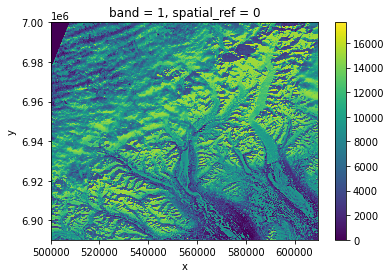

In [21]:
# tif file is read only when needed
data.plot()

### Sentinel-1 image downloading

Below we demontrate how to download the Sentinel-1 GRD images from NASA catalog. 
As the same as Sentinel-2, we first search the available images with satsearch

In [22]:
URL = 'https://cmr.earthdata.nasa.gov/stac/ASF'
bbox = [4.6, 52.3, 4.7, 52.4]  # (min lon, min lat, max lon, max lat) AMS area
collection = 'C1214470533-ASF' # 1A_DUAL_POL_GRD_HIGH_RES
dates = '2019-01-01/2019-01-04'

search_kwargs = dict(
url=URL,
collections=[collection],
datetime=dates,
bbox=bbox)

search = satsearch.Search.search(**search_kwargs)

Then we build a catalog with found items. For this tutorial, we limit our search to 1 item due to the large size of S1 GRD image.

In [23]:
catalog = Catalog(
    id='s1-catalog',
    description='Test catalog for Sentinel-1 data'
)
items = (Item.from_dict(item._data) for item in search.items())
catalog.add_items(items)
catalog.normalize_and_save('./tmp', catalog_type='SELF_CONTAINED')
catalog.describe()

* <Catalog id=s1-catalog>
  * <Item id=G1582185098-ASF>


To retrieve Sentinel-1 images, we need to first get Earthdata login credentials. The credentials can be easily created via [this tutorial](https://wiki.earthdata.nasa.gov/display/EL/How+To+Register+For+an+EarthData+Login+Profile).
After creating the loging credentials, you can fill them in the following blanks.

In [24]:
authentication_nasa = stac2webdav.configure(username='USERNAME',
                                                password='PASSWORD')

This time we download S1 images to the local file system.

In [25]:
assets = ('browse', 'data', 'metadata')

for asset_key in assets:
    download_asset(
        catalog, 
        asset_key, 
        update_catalog=True,  # update the catalog's links to the assets
        authentication_from = authentication_nasa
    )

Downloading: 681KB [00:00, 1046.92KB/s]                                   
Downloading: 1030255KB [03:06, 5526.26KB/s]                                     
Downloading: 1KB [00:00, 5825.42KB/s]                       
